# Synthetic Datasets

## Exponential Decay + Gaussian Signal

#### The first method is predictive analysis, as discussed before. There will be another method introduced, which will analyze the signal parameters.

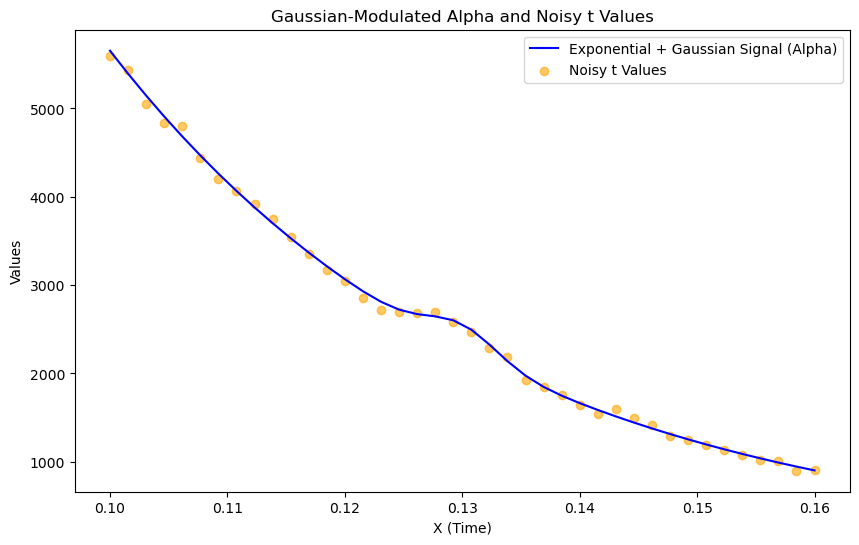

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Constants
np.random.seed(41)
c = np.exp(11.7)  # Constant multiplier
lambda_exp = 30.6  # Decay rate
n_samples = 40  # Number of unique time values
n_instances_per_X = 1  # Number of instances per unique time value

# Generate unique time points (input X values)
X_unique = np.linspace(0.1, 0.16, n_samples)  # Time values

# Parameters for the Gaussian signal
mean_gaussian = 0.13  # Center of the Gaussian peak in X
std_gaussian = 0.003  # Standard deviation of the Gaussian signal
amplitude_gaussian = 300  # Amplitude of the Gaussian signal

# Initialize lists to store the expanded data
X_expanded = []
Alpha_noisy_expanded = []
t_expanded = []

# Iterate over each unique X (time) value
for x in X_unique:
    # Exponential decay component
    alpha_x = c * np.exp(-lambda_exp * x)
    
    # Gaussian signal component
    gaussian_signal = amplitude_gaussian * np.exp(-((x - mean_gaussian) ** 2) / (2 * std_gaussian ** 2))
    
    # Noisy Alpha is the sum of the exponential decay and the Gaussian signal
    alpha_noisy = alpha_x + gaussian_signal
    
    # Generate multiple t values from Poisson distribution with λ = alpha_noisy
    t_values = np.random.poisson(alpha_noisy, n_instances_per_X)
    
    # Append data to lists
    X_expanded.extend([x] * n_instances_per_X)
    Alpha_noisy_expanded.extend([alpha_noisy] * n_instances_per_X)
    t_expanded.extend(t_values)

# Visualization: Combined Plot
plt.figure(figsize=(10, 6))

# Plot Gaussian-modified Alpha
plt.plot(X_unique, 
         [c * np.exp(-lambda_exp * x) + amplitude_gaussian * np.exp(-((x - mean_gaussian) ** 2) / (2 * std_gaussian ** 2)) for x in X_unique],
         label="Exponential + Gaussian Signal (Alpha)", color="blue")

# Scatter plot of noisy t values
plt.scatter(X_expanded, t_expanded, color="orange", alpha=0.6, label="Noisy t Values")

plt.xlabel('X (Time)')
plt.ylabel('Values')
plt.title('Gaussian-Modulated Alpha and Noisy t Values')
plt.legend()
plt.show()


In [15]:
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
import numpy as np
X = np.array(X_expanded)
t = np.array(t_expanded)
# Initial parameters
theta_init = np.array([0.01, 20.0055], dtype=np.float64)

# Define bounds for parameters (e.g., no negative values)
bounds = [(0.0001, 30), (0.01, 30)]  # Both parameters >= 0

# Optimize the log-likelihood using L-BFGS-B
result = minimize(
    fun=neg_log_likelihood_function,  # Objective function
    x0=theta_init,                        # Initial guess
    args=(X, t),                          # Additional arguments for the function
    method='L-BFGS-B',
    bounds=bounds                         # Optional parameter bounds
)

# Print the optimization results
print(f"Optimized parameters: [{result.x[0]:.4f}, {result.x[1]:.4f}]")
print(f"Log-likelihood at optimum: {-result.fun:.4f}")


Optimized parameters: [0.0128, 20.0065]
Log-likelihood at optimum: 738112.0234


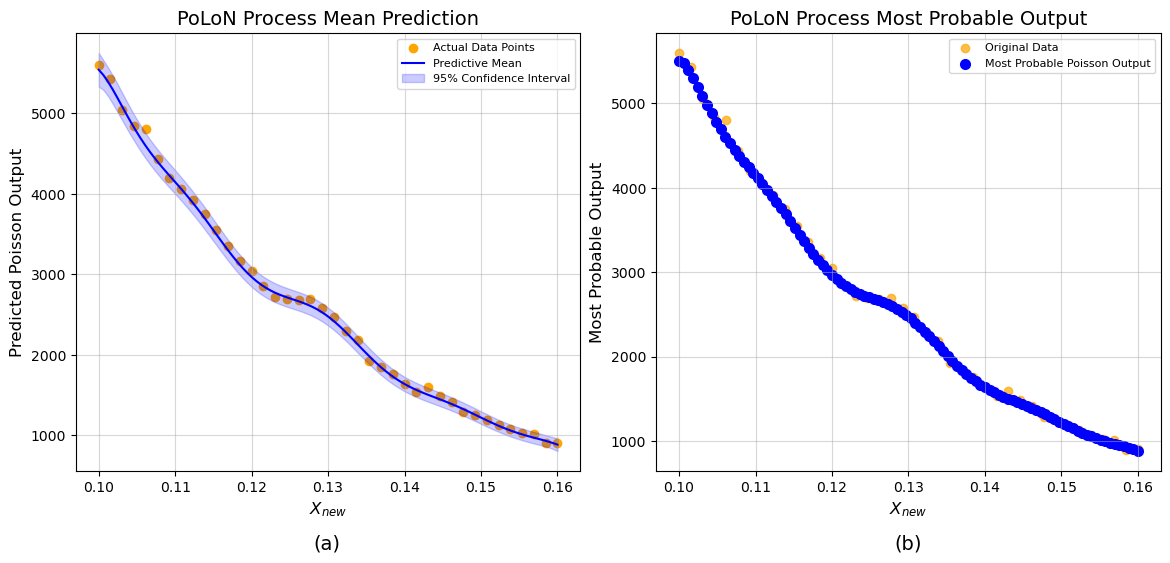

In [7]:
X = np.array(X_expanded)
t = np.array(t_expanded)
Cn = compute_cov_matrix(X,0.0128, 20.0065, regularization=1e-5)
    
# Initialize lambda
lambda_init = np.full(X.shape[0],6.0)

lambda_predicted, _ = newton_optimization(t, Cn, max_iter=25000, tol=1e-5)
from scipy.stats import poisson
# Define input space for predictions
X_input = np.linspace(0.1, 0.16, 100)

# Storage for predictions
mu_values = []
std_values = []

# Loop over each X_new to compute predictive mean and standard deviation
for X_new in X_input:
    K = compute_K(X, X_new,0.0128, 20.0065)  # Compute K for each X_new
    mean_lambda_nplus1_given_data = K.T @ np.linalg.inv(Cn) @ lambda_predicted  # Predictive mean

    # Variance calculations
    H = compute_hessian(Cn, lambda_predicted)
    c = rbf_kernel_extended(X_new, X_new,0.0128, 20.0065) + 1e-5
    var_lambda_nplus1_given_data = abs(
        c - K.T @ np.linalg.inv(Cn) @ K +
        K.T @ np.linalg.inv(Cn) @ np.linalg.inv(H) @ np.linalg.inv(Cn) @ K
    )

    # Append results to the storage
    mu_values.append(mean_lambda_nplus1_given_data.item())
    std_values.append(np.sqrt(var_lambda_nplus1_given_data))

# Convert lists to arrays
mu_values = np.array(mu_values)
std_values = np.array(std_values)

poissoin_output = []
sigma_poissoin = []
for mu, sigma in zip(mu_values, std_values):
    mean_log = mu + sigma**2/2
    poissoin_output.append(np.exp(mean_log))
    sigma_poissoin.append(np.sqrt(np.exp(mean_log)+ np.exp(2* mean_log) * (np.exp(sigma**2) -1)))

    
poissoin_output = np.array(poissoin_output)        
sigma_poissoin = np.array(sigma_poissoin)

# Compute confidence intervals
lower_bound = poissoin_output - 2 * sigma_poissoin
upper_bound = poissoin_output + 2 * sigma_poissoin


# Storage for the most probable Poisson outputs (mode) and probabilities
most_probable_output = []
most_probable_probability = []

# Monte Carlo parameters
n_samples = 5000 # Number of Monte Carlo samples
k_range = np.arange(0, 5500)  # Range of k to evaluate

# Iterate over all X_input to find the most probable Poisson output
for mu, sigma in zip(mu_values, std_values):
    # Sample lambda values from the log-normal distribution
    lambda_samples = np.random.lognormal(mean=mu, sigma=sigma, size=n_samples)
    
    # Calculate probabilities for all k values
    monte_carlo_probabilities = []
    for k in k_range:
        poisson_probabilities = poisson.pmf(k, lambda_samples)
        monte_carlo_probabilities.append(np.mean(poisson_probabilities))
    
    # Find the most probable k (mode)
    k_argmax = k_range[np.argmax(monte_carlo_probabilities)]
    most_probable_output.append(k_argmax)
    most_probable_probability.append(max(monte_carlo_probabilities))

# Convert to arrays for easier plotting
most_probable_output = np.array(most_probable_output)
most_probable_probability = np.array(most_probable_probability)


# Create subplots with a shared layout
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns, adjust figsize as needed

# First plot: Gaussian Process Prediction
#axes[0].plot(X, alpha_x, label="Underlying Function", color="red")
axes[0].scatter(X, t, label="Actual Data Points", color="orange")
axes[0].plot(X_input, poissoin_output, label="Predictive Mean", color="blue")
axes[0].fill_between(X_input, lower_bound, upper_bound, color="blue", alpha=0.2, label="95% Confidence Interval")
axes[0].set_title("PoLoN Process Mean Prediction", fontsize=14)
axes[0].set_xlabel("$X_{new}$", fontsize=12)
axes[0].set_ylabel("Predicted Poisson Output", fontsize=12)
axes[0].legend(fontsize=8)
axes[0].grid(alpha=0.5)

# Second plot: Most Probable Poisson Output
axes[1].scatter(X, t, label="Original Data", color="orange", alpha=0.7)
axes[1].scatter(X_input, most_probable_output, label="Most Probable Poisson Output", color="blue", linewidth=2)
axes[1].set_title("PoLoN Process Most Probable Output", fontsize=14)
axes[1].set_xlabel("$X_{new}$", fontsize=12)
axes[1].set_ylabel("Most Probable Output", fontsize=12)
axes[1].legend(fontsize=8)
axes[1].grid(alpha=0.5)

# Add labels below subplots
fig.text(0.295, 0.02, "(a)", fontsize=14)  # Label for first subplot
fig.text(0.71, 0.02, "(b)", fontsize=14)  # Label for second subplot

# Adjust spacing between the subplots
plt.subplots_adjust(wspace=0.15, bottom=0.15)  # Adjust bottom to create space for labels

# Show the p-lots
plt.show()

#### Varying parameters such as signal strength, number of points per X, or seed will produce different outcomes. Users can explore these variations by changing the inputs to the function calls.

The root mean square errors (RMSE) are computed in parallel across multiple runs and aggregated. The results are visualized in the plot below.

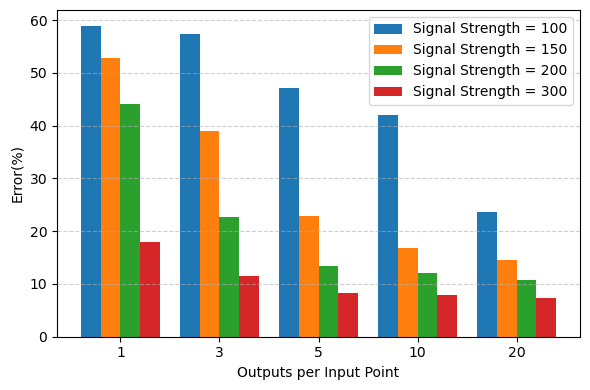

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Load CSV ---
df = pd.read_csv(r"C:\Users\Anushka\Downloads\rmse_avg_normalized_2.csv")  # replace with your file path

# --- Select signal strengths to plot ---
selected_signals = [100, 150, 200, 300]  # pick 3-4 from your CSV

df_plot = df[df['signal_strength'].isin(selected_signals)]

# --- Prepare x-axis ---
x_values = sorted(df_plot['n_points_per_X'].unique())
x_idx = np.arange(len(x_values))
bar_width = 0.2
offsets = np.linspace(-bar_width*(len(selected_signals)-1)/2, 
                      bar_width*(len(selected_signals)-1)/2, len(selected_signals))

plt.figure(figsize=(6,4))

# --- Plot bars ---
for offset, sig in zip(offsets, selected_signals):
    sub_df = df_plot[df_plot['signal_strength'] == sig].set_index('n_points_per_X')
    heights = [sub_df.loc[x, 'rmse_normalized'] * 100 for x in x_values]
    plt.bar(x_idx + offset, heights, width=bar_width, label=f"Signal Strength = {sig}")

plt.xticks(x_idx, x_values)
plt.xlabel("Outputs per Input Point")
plt.ylabel("Error(%)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


#### The second method will be displayed now.

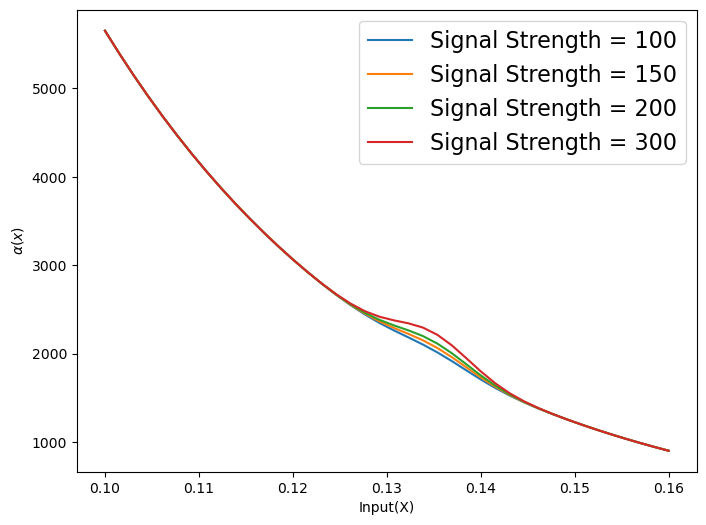

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
c = np.exp(11.7)  # Constant multiplier
lambda_exp = 30.6  # Decay rate
n_samples = 40  # Number of unique time values
X_unique = np.linspace(0.1, 0.16, n_samples)  # Time values

# Gaussian signal strengths to plot
signal_strengths = [100, 150, 200, 300]

# Parameters for the Gaussian signal
mean_gaussian = 0.135  # Center of the Gaussian peak
std_gaussian = 0.004   # Standard deviation of the Gaussian signal

plt.figure(figsize=(8,6))

# Plot alpha(x) for each signal strength
for S in signal_strengths:
    alpha_x = [c * np.exp(-lambda_exp * x) + S * np.exp(-((x - mean_gaussian) ** 2) / (2 * std_gaussian ** 2)) for x in X_unique]
    plt.plot(X_unique, alpha_x, label=f"Signal Strength = {S}")

plt.xlabel('Input(X)')
plt.ylabel(r'$\alpha(x)$')
#plt.title('Poisson Rate Parameter α(x) for Different Signal Strengths')
plt.legend(fontsize = 16)
plt.show()


## S = 300

1 output per input point

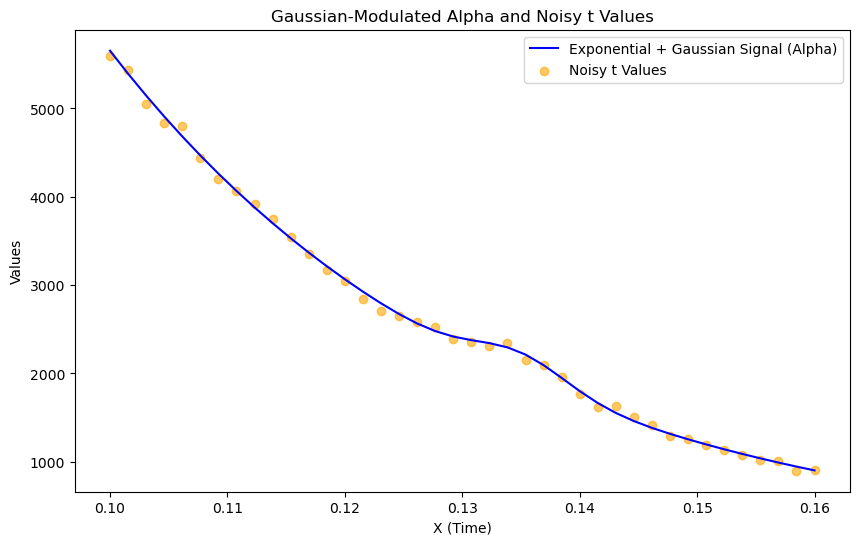

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Constants
np.random.seed(41)
c = np.exp(11.7)  # Constant multiplier
lambda_exp = 30.6  # Decay rate
n_samples = 40  # Number of unique time values
n_instances_per_X = 1 # Number of instances per unique time value

# Generate unique time points (input X values)
X_unique = np.linspace(0.1, 0.16, n_samples)  # Time values

# Parameters for the Gaussian signal
mean_gaussian = 0.135  # Center of the Gaussian peak in X
std_gaussian = 0.004  # Standard deviation of the Gaussian signal
amplitude_gaussian = 300  # Amplitude of the Gaussian signal

# Initialize lists to store the expanded data
X_expanded = []
Alpha_noisy_expanded = []
t_expanded = []

# Iterate over each unique X (time) value
for x in X_unique:
    # Exponential decay component
    alpha_x = c * np.exp(-lambda_exp * x)
    
    # Gaussian signal component
    gaussian_signal = amplitude_gaussian * np.exp(-((x - mean_gaussian) ** 2) / (2 * std_gaussian ** 2))
    
    # Noisy Alpha is the sum of the exponential decay and the Gaussian signal
    alpha_noisy = alpha_x + gaussian_signal
    
    # Generate multiple t values from Poisson distribution with λ = alpha_noisy
    t_values = np.random.poisson(alpha_noisy, n_instances_per_X)
    
    # Append data to lists
    X_expanded.extend([x] * n_instances_per_X)
    Alpha_noisy_expanded.extend([alpha_noisy] * n_instances_per_X)
    t_expanded.extend(t_values)

# Visualization: Combined Plot
plt.figure(figsize=(10, 6))

# Plot Gaussian-modified Alpha
plt.plot(X_unique, 
         [c * np.exp(-lambda_exp * x) + amplitude_gaussian * np.exp(-((x - mean_gaussian) ** 2) / (2 * std_gaussian ** 2)) for x in X_unique],
         label="Exponential + Gaussian Signal (Alpha)", color="blue")

# Scatter plot of noisy t values
plt.scatter(X_expanded, t_expanded, color="orange", alpha=0.6, label="Noisy t Values")

plt.xlabel('X (Time)')
plt.ylabel('Values')
plt.title('Gaussian-Modulated Alpha and Noisy t Values')
plt.legend()
plt.show()


In [17]:
# Background Fit
from scipy.optimize import minimize
from scipy.stats import multivariate_normal

X = np.array(np.concatenate((X_expanded[:18], X_expanded[28:])))
t = np.array(np.concatenate((t_expanded[:18], t_expanded[28:])))

bounds = [(0.0001, 2), (0.01, 50.0)] 
theta_init = np.array([0.05, 20], dtype=np.float64)
result = minimize(
    fun=neg_log_likelihood_function,
    x0=theta_init,
    args=(X, t),
    method='L-BFGS-B',
    bounds=bounds
)
# Print the optimization results
print(f"Optimized parameters: [{result.x[0]:.4f}, {result.x[1]:.3f}]")
print(f"Log-likelihood at optimum: {-result.fun:.3f}")

Optimized parameters: [0.2866, 19.689]
Log-likelihood at optimum: 597793.312


In [18]:
theta = [0.2866, 19.689]
X_bg = np.array(np.concatenate((X_expanded[:18], X_expanded[28:])))
t_bg = np.array(np.concatenate((t_expanded[:18], t_expanded[28:])))

X_signal = np.array(X_expanded[18:28])
t_signal = np.array(t_expanded[18:28])

In [34]:
# Initial guess in scaled space
trans_params0_scaled = [2.5, 1.3, 6.0]  # scaled according to the factors above

# Bounds in scaled space
bounds_scaled = [(0.5, 4), (1.0, 1.4), (1.0, 7.0)]

res = minimize(
    neg_total_loglik_scaled,
    trans_params0_scaled,
    args=(X_bg, t_bg, X_signal, t_signal, theta),
    method="L-BFGS-B",
    bounds=bounds_scaled
)

# Recover original parameters
A_opt = res.x[0] * 100
mu_opt = res.x[1] * 0.1
sigma_opt = res.x[2] * 0.001
print(f"The optimized hyperparameters are --> {A_opt, mu_opt, sigma_opt}")
print(f"The functional value is --> {- res.fun}")

The optimized hyperparameters are --> (278.4736957037175, 0.13514203874294448, 0.004149133698121697)
The functional value is --> -374.47229857070715


3 output per input point

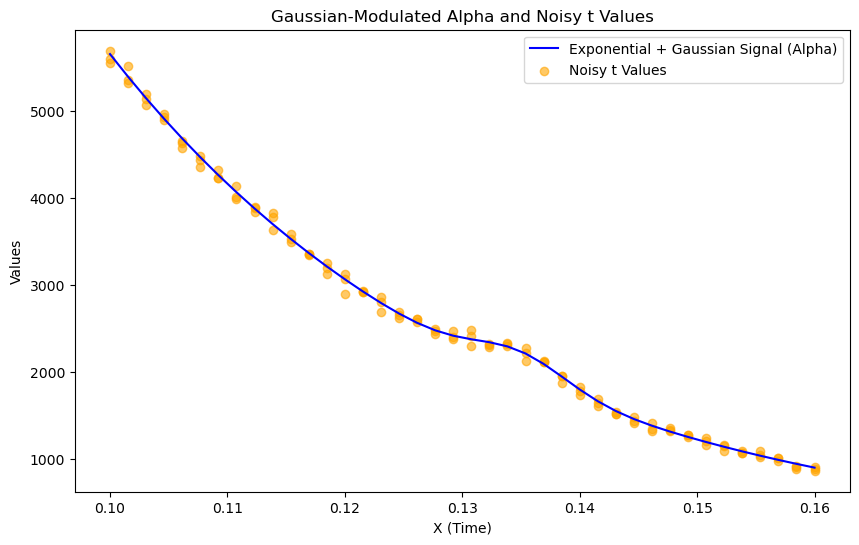

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Constants
np.random.seed(41)
c = np.exp(11.7)  # Constant multiplier
lambda_exp = 30.6  # Decay rate
n_samples = 40  # Number of unique time values
n_instances_per_X = 3 # Number of instances per unique time value

# Generate unique time points (input X values)
X_unique = np.linspace(0.1, 0.16, n_samples)  # Time values

# Parameters for the Gaussian signal
mean_gaussian = 0.135  # Center of the Gaussian peak in X
std_gaussian = 0.004  # Standard deviation of the Gaussian signal
amplitude_gaussian = 300  # Amplitude of the Gaussian signal

# Initialize lists to store the expanded data
X_expanded = []
Alpha_noisy_expanded = []
t_expanded = []

# Iterate over each unique X (time) value
for x in X_unique:
    # Exponential decay component
    alpha_x = c * np.exp(-lambda_exp * x)
    
    # Gaussian signal component
    gaussian_signal = amplitude_gaussian * np.exp(-((x - mean_gaussian) ** 2) / (2 * std_gaussian ** 2))
    
    # Noisy Alpha is the sum of the exponential decay and the Gaussian signal
    alpha_noisy = alpha_x + gaussian_signal
    
    # Generate multiple t values from Poisson distribution with λ = alpha_noisy
    t_values = np.random.poisson(alpha_noisy, n_instances_per_X)
    
    # Append data to lists
    X_expanded.extend([x] * n_instances_per_X)
    Alpha_noisy_expanded.extend([alpha_noisy] * n_instances_per_X)
    t_expanded.extend(t_values)

# Visualization: Combined Plot
plt.figure(figsize=(10, 6))

# Plot Gaussian-modified Alpha
plt.plot(X_unique, 
         [c * np.exp(-lambda_exp * x) + amplitude_gaussian * np.exp(-((x - mean_gaussian) ** 2) / (2 * std_gaussian ** 2)) for x in X_unique],
         label="Exponential + Gaussian Signal (Alpha)", color="blue")

# Scatter plot of noisy t values
plt.scatter(X_expanded, t_expanded, color="orange", alpha=0.6, label="Noisy t Values")

plt.xlabel('X (Time)')
plt.ylabel('Values')
plt.title('Gaussian-Modulated Alpha and Noisy t Values')
plt.legend()
plt.show()


In [37]:
# Background Fit
from scipy.optimize import minimize
from scipy.stats import multivariate_normal

X = np.array(np.concatenate((X_expanded[:54], X_expanded[84:])))
t = np.array(np.concatenate((t_expanded[:54], t_expanded[84:])))

bounds = [(0.0001, 2), (0.01, 50.0)] 
theta_init = np.array([0.286, 20], dtype=np.float64)
result = minimize(
    fun=neg_log_likelihood_function,
    x0=theta_init,
    args=(X, t),
    method='L-BFGS-B',
    bounds=bounds
)
# Print the optimization results
print(f"Optimized parameters: [{result.x[0]:.4f}, {result.x[1]:.3f}]")
print(f"Log-likelihood at optimum: {-result.fun:.3f}")

Optimized parameters: [0.3027, 19.994]
Log-likelihood at optimum: 1794122.546


In [38]:
theta = [0.3027, 19.994]
X_bg = np.array(np.concatenate((X_expanded[:54], X_expanded[84:])))
t_bg = np.array(np.concatenate((t_expanded[:54], t_expanded[84:])))

X_signal = np.array(X_expanded[54:84])
t_signal = np.array(t_expanded[54:84])

In [54]:
# Initial guess in scaled space
trans_params0_scaled = [2.5, 1.2, 6.0]  # scaled according to the factors above

# Bounds in scaled space
bounds_scaled = [(0.5, 4), (1.0, 1.5), (1.0, 7.0)]

res = minimize(
    neg_total_loglik_scaled,
    trans_params0_scaled,
    args=(X_bg, t_bg, X_signal, t_signal, theta),
    method="L-BFGS-B",
    bounds=bounds_scaled
)

# Recover original parameters
A_opt = res.x[0] * 100
mu_opt = res.x[1] * 0.1
sigma_opt = res.x[2] * 0.001
print(f"The optimized hyperparameters are --> {A_opt, mu_opt, sigma_opt}")
print(f"The functional value is --> {- res.fun}")

The optimized hyperparameters are --> (307.67171989613007, 0.13490579858490548, 0.0037442863491113526)
The functional value is --> -1137.4042264288503


5 output per input point

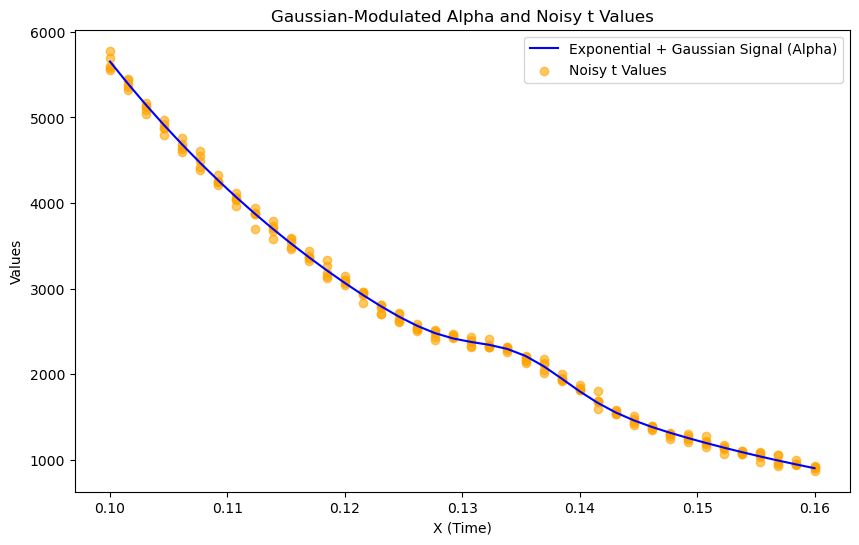

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Constants
np.random.seed(41)
c = np.exp(11.7)  # Constant multiplier
lambda_exp = 30.6  # Decay rate
n_samples = 40  # Number of unique time values
n_instances_per_X = 5 # Number of instances per unique time value

# Generate unique time points (input X values)
X_unique = np.linspace(0.1, 0.16, n_samples)  # Time values

# Parameters for the Gaussian signal
mean_gaussian = 0.135  # Center of the Gaussian peak in X
std_gaussian = 0.004  # Standard deviation of the Gaussian signal
amplitude_gaussian = 300  # Amplitude of the Gaussian signal

# Initialize lists to store the expanded data
X_expanded = []
Alpha_noisy_expanded = []
t_expanded = []

# Iterate over each unique X (time) value
for x in X_unique:
    # Exponential decay component
    alpha_x = c * np.exp(-lambda_exp * x)
    
    # Gaussian signal component
    gaussian_signal = amplitude_gaussian * np.exp(-((x - mean_gaussian) ** 2) / (2 * std_gaussian ** 2))
    
    # Noisy Alpha is the sum of the exponential decay and the Gaussian signal
    alpha_noisy = alpha_x + gaussian_signal
    
    # Generate multiple t values from Poisson distribution with λ = alpha_noisy
    t_values = np.random.poisson(alpha_noisy, n_instances_per_X)
    
    # Append data to lists
    X_expanded.extend([x] * n_instances_per_X)
    Alpha_noisy_expanded.extend([alpha_noisy] * n_instances_per_X)
    t_expanded.extend(t_values)

# Visualization: Combined Plot
plt.figure(figsize=(10, 6))

# Plot Gaussian-modified Alpha
plt.plot(X_unique, 
         [c * np.exp(-lambda_exp * x) + amplitude_gaussian * np.exp(-((x - mean_gaussian) ** 2) / (2 * std_gaussian ** 2)) for x in X_unique],
         label="Exponential + Gaussian Signal (Alpha)", color="blue")

# Scatter plot of noisy t values
plt.scatter(X_expanded, t_expanded, color="orange", alpha=0.6, label="Noisy t Values")

plt.xlabel('X (Time)')
plt.ylabel('Values')
plt.title('Gaussian-Modulated Alpha and Noisy t Values')
plt.legend()
plt.show()


In [56]:
# Background Fit
from scipy.optimize import minimize
from scipy.stats import multivariate_normal

X = np.array(np.concatenate((X_expanded[:90], X_expanded[140:])))
t = np.array(np.concatenate((t_expanded[:90], t_expanded[140:])))

bounds = [(0.0001, 2), (0.01, 50.0)] 
theta_init = np.array([0.286, 20], dtype=np.float64)
result = minimize(
    fun=neg_log_likelihood_function,
    x0=theta_init,
    args=(X, t),
    method='L-BFGS-B',
    bounds=bounds
)
# Print the optimization results
print(f"Optimized parameters: [{result.x[0]:.4f}, {result.x[1]:.3f}]")
print(f"Log-likelihood at optimum: {-result.fun:.3f}")

Optimized parameters: [0.3351, 25.410]
Log-likelihood at optimum: 2991959.545


In [57]:
theta = [0.3351, 25.410]
X_bg = np.array(np.concatenate((X_expanded[:90], X_expanded[140:])))
t_bg = np.array(np.concatenate((t_expanded[:90], t_expanded[140:])))

X_signal = np.array(X_expanded[90:140])
t_signal = np.array(t_expanded[90:140])

In [74]:
# Initial guess in scaled space
trans_params0_scaled = [2.5, 1.2, 6.0]  # scaled according to the factors above

# Bounds in scaled space
bounds_scaled = [(0.5, 4), (1.0, 1.5), (1.0, 7.0)]

res = minimize(
    neg_total_loglik_scaled,
    trans_params0_scaled,
    args=(X_bg, t_bg, X_signal, t_signal, theta),
    method="L-BFGS-B",
    bounds=bounds_scaled
)

# Recover original parameters
A_opt = res.x[0] * 100
mu_opt = res.x[1] * 0.1
sigma_opt = res.x[2] * 0.001
print(f"The optimized hyperparameters are --> {A_opt, mu_opt, sigma_opt}")
print(f"The functional value is --> {- res.fun}")

The optimized hyperparameters are --> (292.93799337216024, 0.1351669204440861, 0.004216960962895349)
The functional value is --> -1909.3472471801558


#### Similar experiments were run using different signal strengths, number of outputs per input point, and random seeds. Then the normalized RMSE is calculated in the signal window, and the average results of those runs are presented below, for the second method. For more details, refer to the paper.

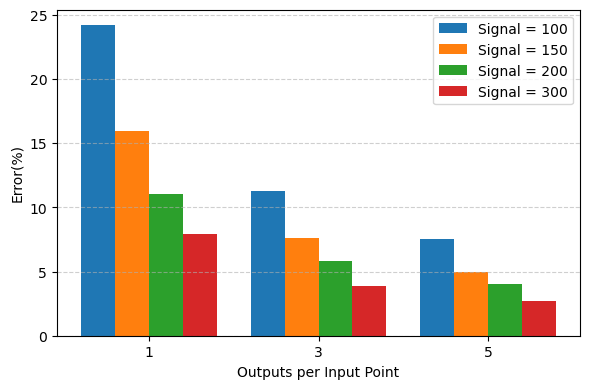

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Load CSV ---
df = pd.read_csv(r"C:\Users\Anushka\Downloads\rmse_avg_normalized_BGS.csv")  # replace with your file path

# --- Select signal strengths to plot ---
selected_signals = [100, 150, 200, 300]  # pick 3-4 from your CSV

df_plot = df[df['signal_strength'].isin(selected_signals)]

# --- Prepare x-axis ---
x_values = sorted(df_plot['n_points_per_X'].unique())
x_idx = np.arange(len(x_values))
bar_width = 0.2
offsets = np.linspace(-bar_width*(len(selected_signals)-1)/2, 
                      bar_width*(len(selected_signals)-1)/2, len(selected_signals))

plt.figure(figsize=(6,4))

# --- Plot bars ---
for offset, sig in zip(offsets, selected_signals):
    sub_df = df_plot[df_plot['signal_strength'] == sig].set_index('n_points_per_X')
    heights = [sub_df.loc[x, 'avg_rmse_normalized'] * 100 for x in x_values]
    plt.bar(x_idx + offset, heights, width=bar_width, label=f"Signal = {sig}")

plt.xticks(x_idx, x_values)
plt.xlabel("Outputs per Input Point")
plt.ylabel("Error(%)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


#### Comparison of the two methodes, the second method notably performs better. 

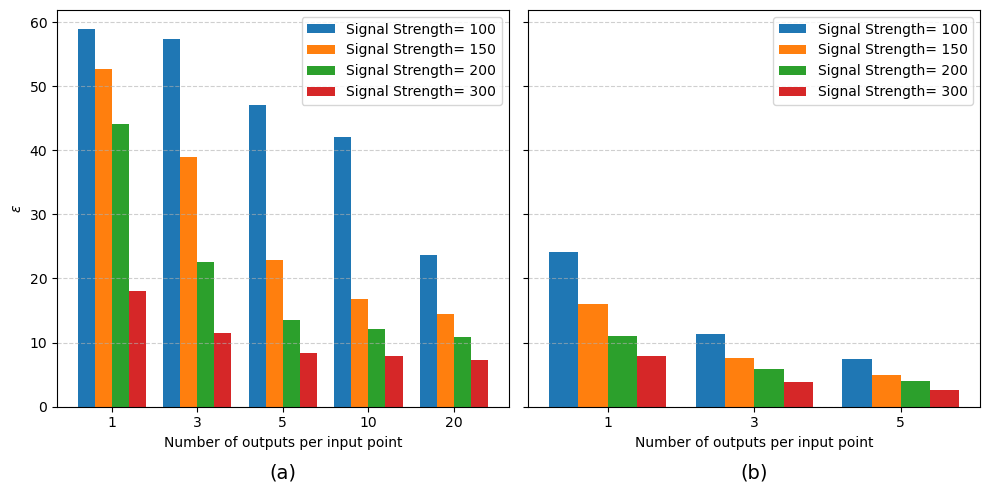

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Load CSVs ---
df1 = pd.read_csv(r"C:\Users\Anushka\Downloads\rmse_avg_normalized_2.csv")
df2 = pd.read_csv(r"C:\Users\Anushka\Downloads\rmse_avg_normalized_BGS.csv")

# --- Select specific signal strengths to plot ---
selected_signals = [100, 150, 200, 300]

# --- Prepare x-axis automatically from CSV ---
x_values1 = sorted(df1['n_points_per_X'].unique())
x_idx1 = np.arange(len(x_values1))
bar_width = 0.2
offsets1 = np.linspace(-bar_width*(len(selected_signals)-1)/2, 
                       bar_width*(len(selected_signals)-1)/2, len(selected_signals))

x_values2 = sorted(df2['n_points_per_X'].unique())
x_idx2 = np.arange(len(x_values2))
offsets2 = np.linspace(-bar_width*(len(selected_signals)-1)/2, 
                       bar_width*(len(selected_signals)-1)/2, len(selected_signals))

# --- Create subplots ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True)

# --- Plot for first CSV ---
for offset, sig in zip(offsets1, selected_signals):
    sub_df = df1[df1['signal_strength'] == sig].set_index('n_points_per_X')
    heights = [sub_df.loc[x, 'rmse_normalized'] * 100 for x in x_values1]
    ax1.bar(x_idx1 + offset, heights, width=bar_width, label=f"Signal Strength= {sig}")
ax1.set_xticks(x_idx1)
ax1.set_xticklabels(x_values1)
ax1.set_xlabel("Number of outputs per input point")
ax1.set_ylabel(r"$\epsilon$")
ax1.grid(axis="y", linestyle="--", alpha=0.6)
ax1.legend()
ax1.text(0.5, -0.18, "(a)", transform=ax1.transAxes, ha='center', fontsize=14)

# --- Plot for second CSV ---
for offset, sig in zip(offsets2, selected_signals):
    sub_df = df2[df2['signal_strength'] == sig].set_index('n_points_per_X')
    heights = [sub_df.loc[x, 'avg_rmse_normalized'] * 100 for x in x_values2]
    ax2.bar(x_idx2 + offset, heights, width=bar_width, label=f"Signal Strength= {sig}")
ax2.set_xticks(x_idx2)
ax2.set_xticklabels(x_values2)
ax2.set_xlabel("Number of outputs per input point")
ax2.grid(axis="y", linestyle="--", alpha=0.6)
ax2.legend()
ax2.text(0.5, -0.18, "(b)", transform=ax2.transAxes, ha='center', fontsize=14)

plt.tight_layout()
plt.show()


## Error of the signal paremeter prediction

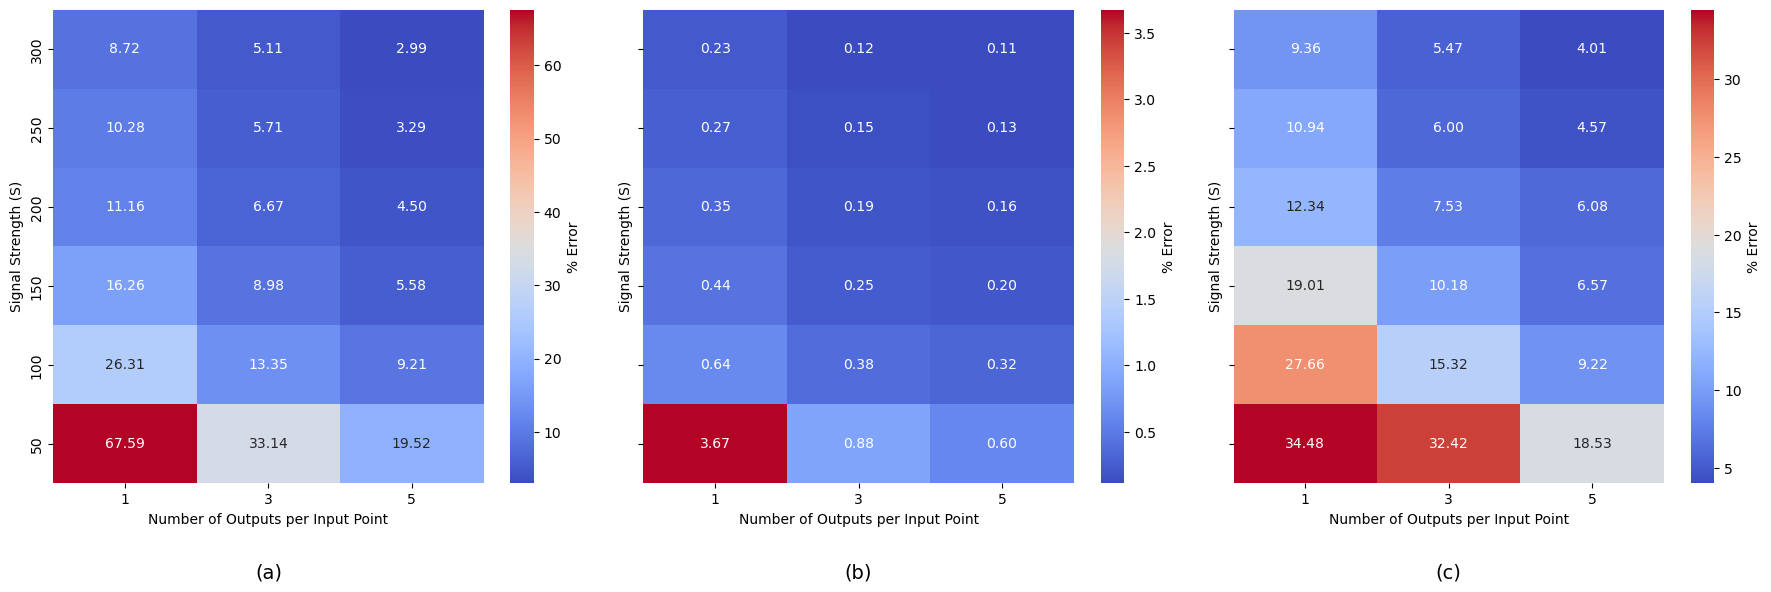

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv(r"C:\Users\Anushka\Downloads\results_avg_over_seeds.csv")

# Pivot the data for heatmaps: rows = signal_strength, columns = n_points_per_X
def create_heatmap_data(df, error_col):
    heatmap_data = df.pivot(index="signal_strength", columns="n_points", values=error_col)
    heatmap_data = heatmap_data.sort_index(ascending=True)
    return heatmap_data

# Error columns
errors = {
    "Signal Strength": "avg_abs_perc_error_A",
    "Mean (μ)": "avg_abs_perc_error_mu",
    "Std (σ)": "avg_abs_perc_error_sigma"
}

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, (label, col) in zip(axes, errors.items()):
    data = create_heatmap_data(df, col)
    sns.heatmap(data, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': '% Error'}, ax=ax)
    ax.invert_yaxis()
    ax.set_xlabel("Number of Outputs per Input Point")
    ax.set_ylabel("Signal Strength (S)")
    # Add (a), (b), (c) at the bottom center
    ax.text(0.5, -0.2, f"({chr(97 + list(errors.keys()).index(label))})", 
            transform=ax.transAxes, fontsize=14, ha='center')

plt.tight_layout()
plt.show()


# Real Dataset - Higgs Boson Signal - Using the background + signal analysis

<ErrorbarContainer object of 3 artists>

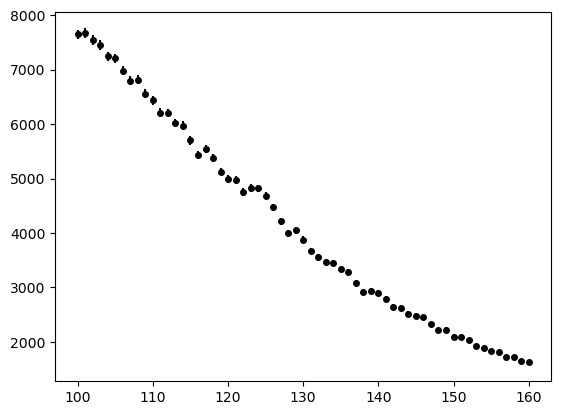

In [1]:
import numpy as np
import matplotlib.pyplot as plt
unbinned_data = np.load("C:/Users/Anushka/Downloads/unbinned_diohoton_mass.npy")
#To plot the results

# x-axis range of the plot

xmin = 99.5 #GeV
xmax = 160.5 #GeV
# Histogram bin setup
step_size = 1 #GeV

bin_edges = np.arange(start=xmin, # The interval includes this value

                    stop=xmax+step_size, # The interval doesn't include this value

                    step=step_size ) # Spacing between values

bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value

                        stop=xmax+step_size/2, # The interval doesn't include this value

                        step=step_size )

data_x,_ = np.histogram(unbinned_data, bins=bin_edges )
data_x_errors = np.sqrt( data_x ) # Approximate statistical error on the data
plt.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,

                fmt='ko', # 'k' means black and 'o' means circles

                label='Data', markersize=4 )

In [71]:
theta = (0.1081, 21.253)
X_bg_he = np.array(np.concatenate((bin_centres[:19],bin_centres[31:])))
t_bg_he = np.array(np.concatenate((data_x[:19], data_x[31:])))
Cn_he = compute_cov_matrix(X_bg_he, *theta)
lambda_n_star_he, _ = newton_optimization(t_bg_he, Cn_he)
X_bg_he = X_bg_he/1000



X_signal_he = np.array(bin_centres[19:31])
X_signal_he = X_signal_he/1000
t_signal_he = np.array(data_x[19:31])

In [199]:
# Background Fit
from scipy.optimize import minimize
from scipy.stats import multivariate_normal

X = np.array(np.concatenate((bin_centres[:19], bin_centres[31:])))
t = np.array(np.concatenate((data_x[:19], data_x[31:])))
X = X/1000

bounds = [(0.01, 2), (0.01, 50.0)] 
theta_init = np.array([0.05, 20], dtype=np.float64)
result = minimize(
    fun=neg_log_likelihood_function,
    x0=theta_init,
    args=(X, t),
    method='L-BFGS-B',
    bounds=bounds
)
# Print the optimization results
print(f"Optimized parameters: [{result.x[0]:.4f}, {result.x[1]:.3f}]")
print(f"Log-likelihood at optimum: {-result.fun:.3f}")

Optimized parameters: [0.1081, 21.253]
Log-likelihood at optimum: 1488829.269


In [74]:
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
# Initial guess in scaled space
trans_params0_scaled = [3.5, 1.25, 2.0]  # scaled according to the factors above

# Bounds in scaled space
bounds_scaled = [(0.5, 4), (1.0, 1.4), (1.0, 7.0)]

res = minimize(
    neg_total_loglik_scaled,
    trans_params0_scaled,
    args=(X_bg_he, t_bg_he, X_signal_he, t_signal_he, theta),
    method="L-BFGS-B",
    bounds=bounds_scaled
)

# Recover original parameters
A_opt = res.x[0] * 100
mu_opt = res.x[1] * 0.1
sigma_opt = res.x[2] * 0.001
print(f"The optimized hyperparameters are --> {A_opt, mu_opt, sigma_opt}")
print(f"The functional value is --> {- res.fun}")

The optimized hyperparameters are --> (321.69712090850095, 0.12456962003899447, 0.0012473130937856501)
The functional value is --> -602.5485031727002


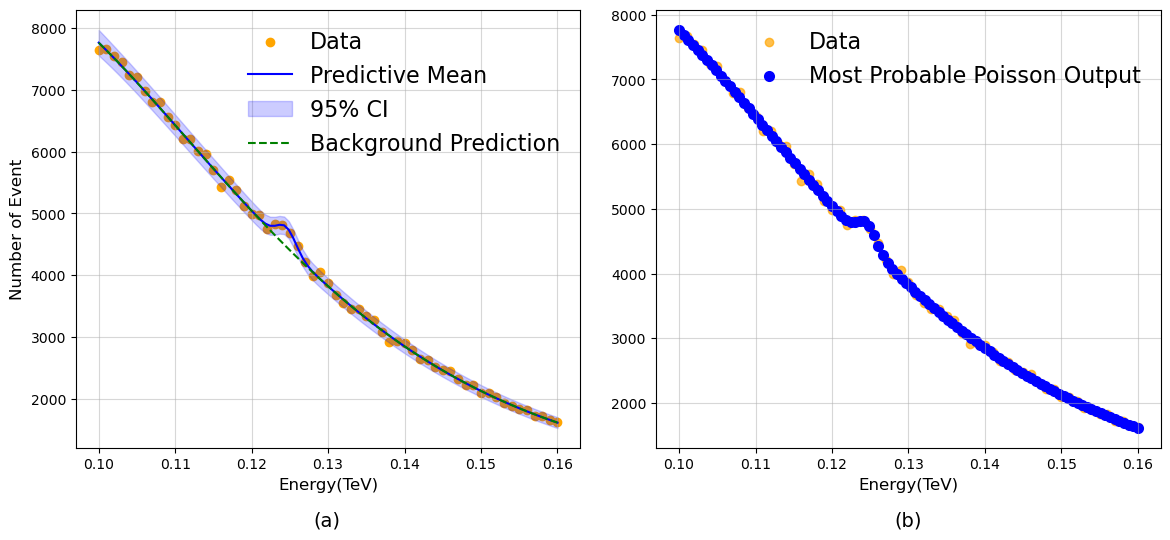

In [4]:
X = np.array(np.concatenate((bin_centres[:19], bin_centres[31:])))
t = np.array(np.concatenate((data_x[:19], data_x[31:])))
X = X/1000

theta = [0.1081, 21.253]

# Compute the covariance matrix
Cn = compute_cov_matrix(X, *theta)

# Optimize lambda_n_star using Newton's method
lambda_n_star, _ = newton_optimization(t, Cn)

A = 321.697
mu = 0.124569
sigma = 0.001247

from scipy.stats import poisson
# Define input space for predictions
X_input = np.linspace(0.1, 0.16, 100)

lambda_predicted = lambda_n_star
# Storage for predictions
mu_values = []
std_values = []
gaussian_signal = []
# Loop over each X_new to compute predictive mean and standard deviation
for X_new in X_input:
    K = compute_K(X, X_new,0.1081, 21.253)  # Compute K for each X_new
    mean_lambda_nplus1_given_data = K.T @ np.linalg.inv(Cn) @ lambda_predicted  # Predictive mean

    # Variance calculations
    H = compute_hessian(Cn, lambda_predicted)
    c = rbf_kernel_extended(X_new, X_new,0.1081, 21.253) + 1e-5
    var_lambda_nplus1_given_data = abs(
        c - K.T @ np.linalg.inv(Cn) @ K +
        K.T @ np.linalg.inv(Cn) @ np.linalg.inv(H) @ np.linalg.inv(Cn) @ K
    )

    # Append results to the storage
    mu_values.append(mean_lambda_nplus1_given_data.item())
    std_values.append(np.sqrt(var_lambda_nplus1_given_data))
    gaussian_signal.append(A * np.exp(-((X_new - mu) ** 2) / (2 * sigma ** 2)))

# Convert lists to arrays
mu_values = np.array(mu_values)
std_values = np.array(std_values)

poissoin_output = []
sigma_poissoin = []

for mu, sigma, g in zip(mu_values, std_values, gaussian_signal ):
    mean_log = mu + sigma**2/2
    poissoin_output.append(np.exp(mean_log) + g)
    sigma_poissoin.append(np.sqrt(np.exp(mean_log)+ np.exp(2* mean_log) * (np.exp(sigma**2) -1)))

    
poissoin_output = np.array(poissoin_output)        
sigma_poissoin = np.array(sigma_poissoin)

# Compute confidence intervals
lower_bound = poissoin_output - 2 * sigma_poissoin
upper_bound = poissoin_output + 2 * sigma_poissoin


# Storage for the most probable Poisson outputs (mode) and probabilities
most_probable_output = []
confidence_intervals = []

# Monte Carlo parameters
n_samples = 5000 # Number of Monte Carlo samples
k_range = np.arange(0, 8100)  # Range of k to evaluate

# Iterate over all X_input to find the most probable Poisson output
for mu, sigma, g in zip(mu_values, std_values, gaussian_signal):
    # Sample lambda values from the log-normal distribution
    lambda_samples = np.random.lognormal(mean=mu, sigma=sigma, size=n_samples)
    
    # Calculate probabilities for all k values
    monte_carlo_probabilities = []
    for k in k_range:
        poisson_probabilities = poisson.pmf(k, lambda_samples + g)
        monte_carlo_probabilities.append(np.mean(poisson_probabilities))
    
    monte_carlo_probabilities = np.array(monte_carlo_probabilities)
    cdf = np.cumsum(monte_carlo_probabilities)

    # Find confidence interval bounds
    lower_prob = 0.025
    upper_prob = 0.975
    k_lower = k_range[np.searchsorted(cdf, lower_prob)]
    k_upper = k_range[np.searchsorted(cdf, upper_prob)]

    # Store most probable output and confidence intervals
    k_argmax = k_range[np.argmax(monte_carlo_probabilities)]
    most_probable_output.append(k_argmax)
    confidence_intervals.append((k_lower, k_upper))
    

# Convert to arrays for easier plotting
most_probable_output = np.array(most_probable_output)
confidence_intervals = np.array(confidence_intervals)

# Extract confidence intervals
lower_bounds = confidence_intervals[:, 0]
upper_bounds = confidence_intervals[:, 1]


# Background-only Poisson output (without Gaussian signal g)
poisson_background = []
sigma_background = []

for mu, sigma in zip(mu_values, std_values):
    mean_log = mu + sigma**2/2
    poisson_background.append(np.exp(mean_log))
    sigma_background.append(np.sqrt(np.exp(mean_log) + np.exp(2*mean_log)*(np.exp(sigma**2)-1)))

poisson_background = np.array(poisson_background)
sigma_background = np.array(sigma_background)
lower_bound_bg = poisson_background - 2 * sigma_background
upper_bound_bg = poisson_background + 2 * sigma_background


X_tot = np.array(bin_centres)
X_tot = X_tot/1000
t_tot = np.array(data_x)

# Create subplots with a shared layout
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns, adjust figsize as needed

# First plot: Gaussian Process Prediction
#axes[0].plot(X, alpha_x, label="Underlying Function", color="red")
axes[0].scatter(X_tot, t_tot, label="Data", color="orange")
axes[0].plot(X_input, poissoin_output, label="Predictive Mean", color="blue")
axes[0].fill_between(X_input, lower_bound, upper_bound, color="blue", alpha=0.2, label="95% CI")
axes[0].plot(X_input, poisson_background, label="Background Prediction", color="green", linestyle="--")
axes[0].set_xlabel("Energy(TeV)", fontsize=12)
axes[0].set_ylabel("Number of Event", fontsize=12)
axes[0].legend(fontsize=16, loc ="best", frameon=False)
axes[0].grid(alpha=0.5)

# Second plot: Most Probable Poisson Output
axes[1].scatter(X_tot, t_tot, label="Data", color="orange", alpha=0.7)
axes[1].scatter(X_input, most_probable_output, label="Most Probable Poisson Output", color="blue", linewidth=2)
axes[1].set_xlabel("Energy(TeV)", fontsize=12)
axes[1].legend(fontsize=16,  loc ="best", frameon=False)
axes[1].grid(alpha=0.5)

# Add labels below subplots
fig.text(0.295, 0.02, "(a)", fontsize=14)  # Label for first subplot
fig.text(0.71, 0.02, "(b)", fontsize=14)  # Label for second subplot

# Adjust spacing between the subplots
plt.subplots_adjust(wspace=0.15, bottom=0.15)  # Adjust bottom to create space for labels

# Show the plots
plt.show()

Maximum sigma difference (signal vs background) in signal window: 4.45 σ


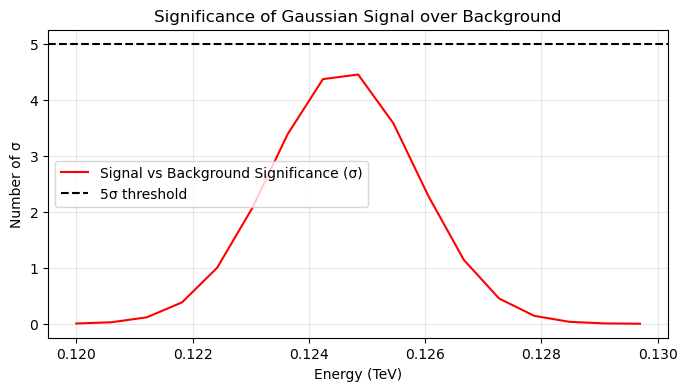

In [5]:
import numpy as np

# Convert lists to arrays if not already
poissoin_output = np.array(poissoin_output)      # Signal + background mean
sigma_poissoin = np.array(sigma_poissoin)        # Uncertainty for signal + background

poisson_background = np.array(poisson_background)  # Background-only mean
sigma_background = np.array(sigma_background)      # Uncertainty for background-only

# Compute point-by-point sigma difference
# Number of sigma by which signal+background differs from background-only
sigma_difference = (poissoin_output - poisson_background) / sigma_background

# Optional: focus only on signal window around Gaussian peak
signal_window_mask = (X_input >= 0.12) & (X_input <= 0.13)
X_window = X_input[signal_window_mask]
sigma_window = sigma_difference[signal_window_mask]

# Maximum sigma difference in signal window
max_sigma_diff = np.max(sigma_window)
print(f"Maximum sigma difference (signal vs background) in signal window: {max_sigma_diff:.2f} σ")

# Plot the sigma difference
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(X_window, sigma_window, color="red", label="Signal vs Background Significance (σ)")
plt.axhline(5, color="black", linestyle="--", label="5σ threshold")
plt.xlabel("Energy (TeV)")
plt.ylabel("Number of σ")
plt.title("Significance of Gaussian Signal over Background")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
